In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import glob
import os

# POLOCM2 BASELINE acceptance rate

In [13]:


# Read and clean
folder_path = "../../output/p2/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df = df[df['remark'] != 'Timeout']
df.columns = df.columns.str.strip()
df['len%'] = df['len%'].astype(float) * 100.0
print(df.head)



<bound method NDFrame.head of          id  dod  actual_dod       domain  index  total_length      len%  \
0         0  0.1    0.133333  blocksworld      0            10  0.201857   
1        28  0.1    0.105263  blocksworld      0            20  0.403714   
2         1  0.1    0.111111  blocksworld      1            10  0.201857   
3        29  0.1    0.106061  blocksworld      1            12  0.242229   
4         2  0.1    0.111111  blocksworld      3            10  0.201857   
...     ...  ...         ...          ...    ...           ...       ...   
13271  1283  1.0    1.000000    transport      8            12  0.278035   
13273  1284  1.0    1.000000    transport      9            50  1.158480   
13275  1308  1.0    1.000000    transport      3            48  1.112141   
13279  1310  1.0    1.000000    transport      5            40  0.926784   
13280  1311  1.0    1.000000    transport      6            40  0.926784   

          runtime  polocm_time  locm2_time  locm_time  ac

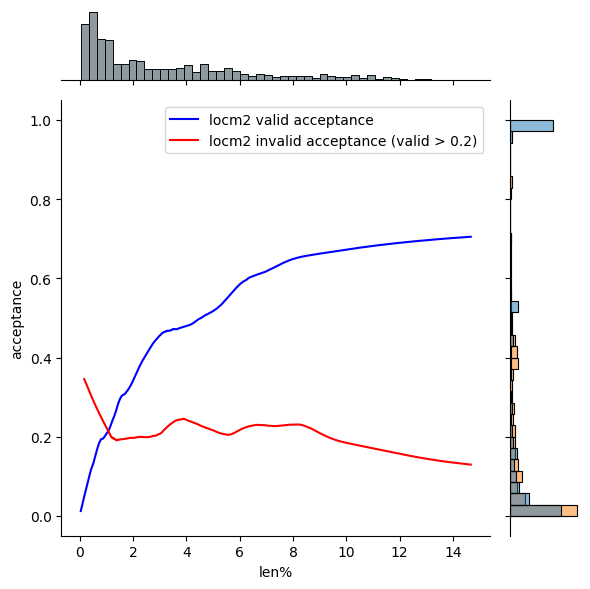

In [22]:
df_by_len = df.sort_values(by='len%')
# Apply LOWESS to full valid_exe
valid_smoothed = lowess(df_by_len['acceptance_rate'], df_by_len['len%'], frac=0.3)
filtered_df = df_by_len[df_by_len['acceptance_rate'] > 0.3]
invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['len%'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_len, id_vars=['len%'], value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
                  var_name='type', value_name='acceptance')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='len%', y='acceptance', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], label='locm2 valid acceptance', color='blue')
plt.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], label='locm2 invalid acceptance (valid > 0.2)', color='red')



plt.legend()
plt.tight_layout()
plt.show()

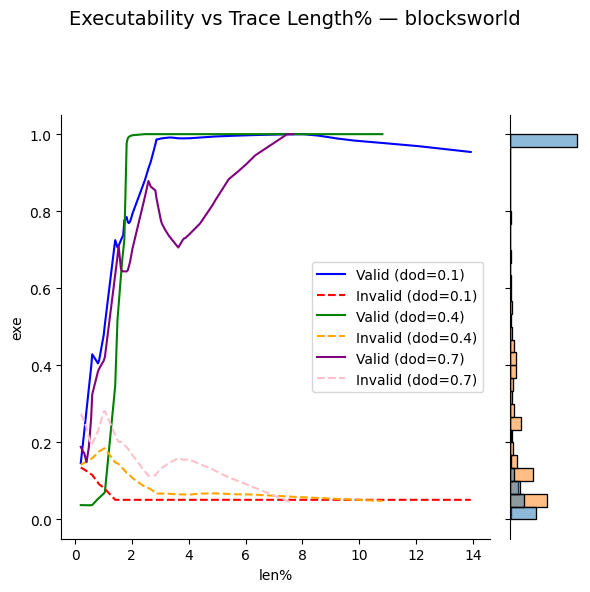

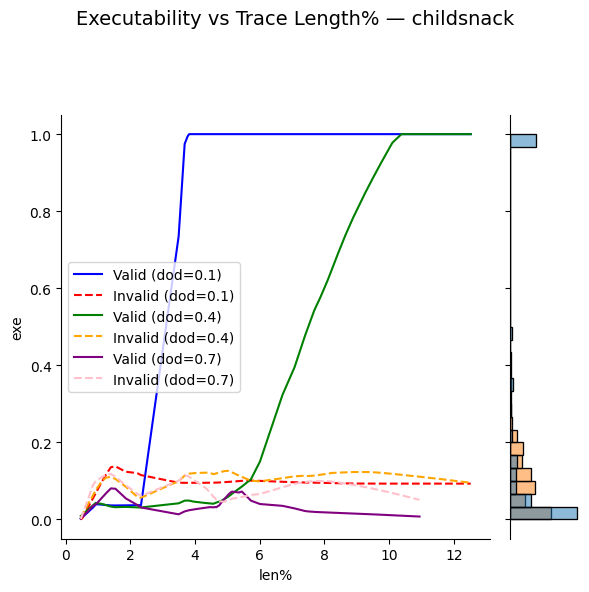

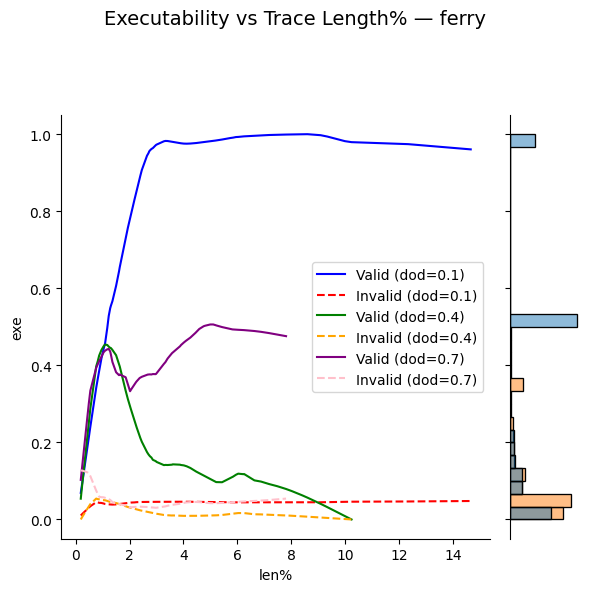

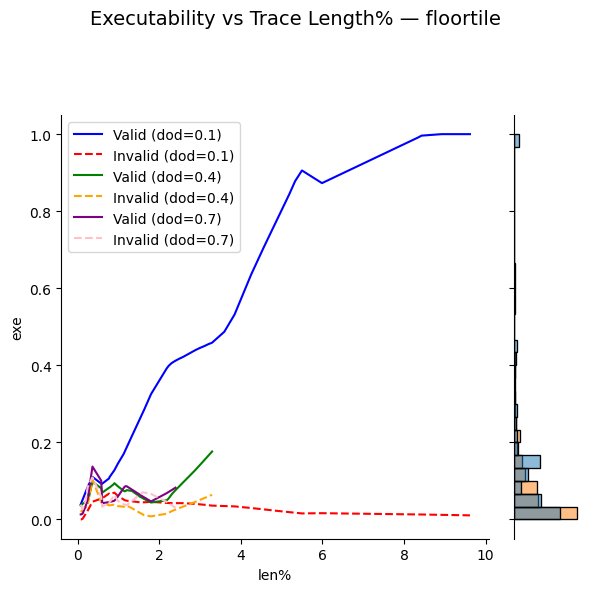

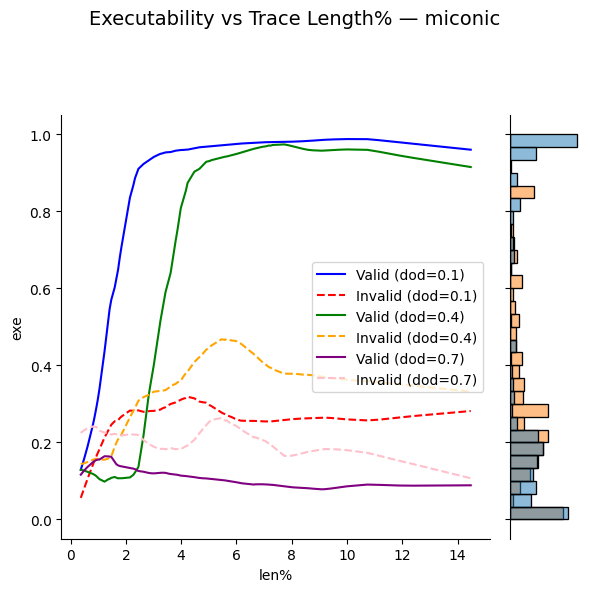

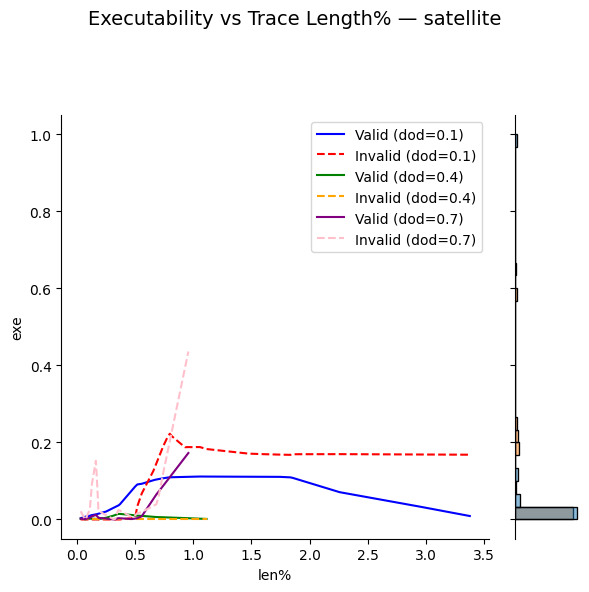

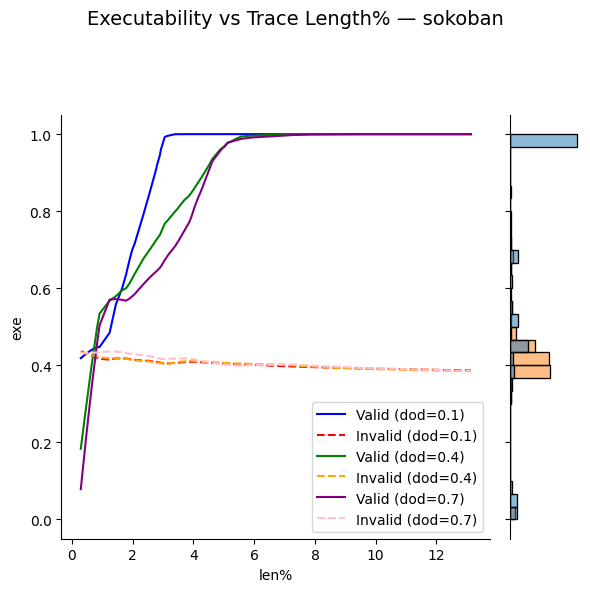

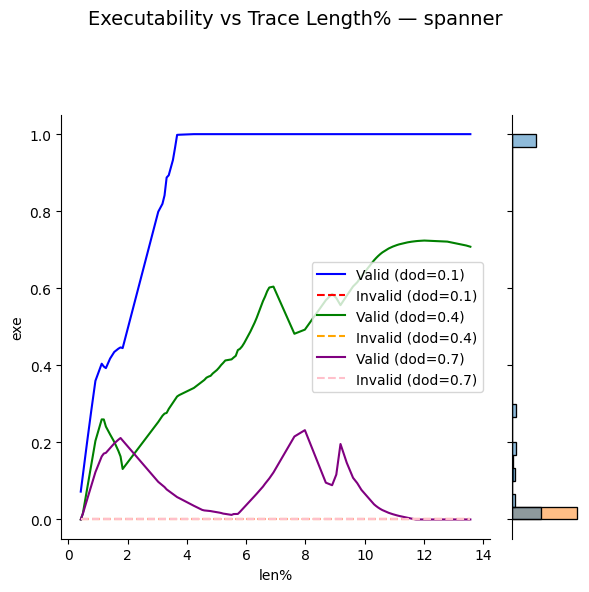

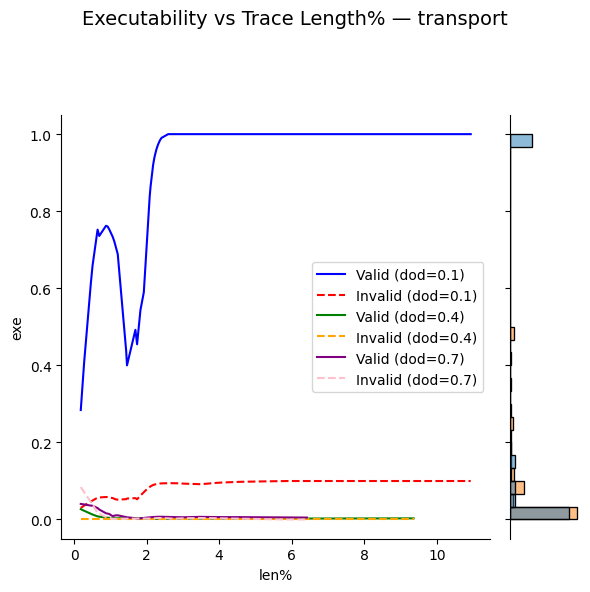

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import pandas as pd
import numpy as np

flexs = [0.1, 0.4, 0.7]
flex_colors = {0.1: ('blue', 'red'), 0.4: ('green', 'orange'), 0.7: ('purple', 'pink')}

domains = df['domain'].unique()

for domain in domains:
    # Prepare the plot base using all data in this domain
    domain_df = df_by_len[df_by_len['domain'] == domain].copy()
    
    # Melt only the domain_df for the histograms (covering all flexs)
    df_long = pd.melt(
        domain_df,
        id_vars=['len%'],
        value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
        var_name='type',
        value_name='exe'
    )

    # Seaborn jointplot (just once per domain)
    g = sns.jointplot(
        data=df_long,
        x='len%', y='exe', hue='type',
        kind='hist', alpha=0,
        height=6, marginal_kws=dict(common_norm=False, stat='density', bins=30)
    )
    g.ax_marg_x.set_visible(False)

    # Overlay LOWESS lines per flex level
    for flex in flexs:
        sub_df = domain_df[domain_df['dod'] == flex]


        valid_smoothed = lowess(sub_df['acceptance_rate'], sub_df['len%'], frac=0.3)
        # filtered_df = sub_df[sub_df['acceptance_rate'] > 0.3]
        invalid_smoothed = lowess(sub_df['invalid_acceptance_rate'], sub_df['len%'], frac=0.3)

        valid_smoothed[:, 1] = np.clip(valid_smoothed[:, 1], 0, 1)
        invalid_smoothed[:, 1] = np.clip(invalid_smoothed[:, 1], 0, 1)

        color = flex_colors[flex]
        g.ax_joint.plot(valid_smoothed[:, 0], valid_smoothed[:, 1],
                        label=f'Valid (dod={flex})', color=color[0], linestyle='-')
        g.ax_joint.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1],
                        label=f'Invalid (dod={flex})', color=color[1], linestyle='--')

    g.ax_joint.legend()
    g.fig.suptitle(f"Executability vs Trace Length% — {domain}", fontsize=14)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    plt.show()


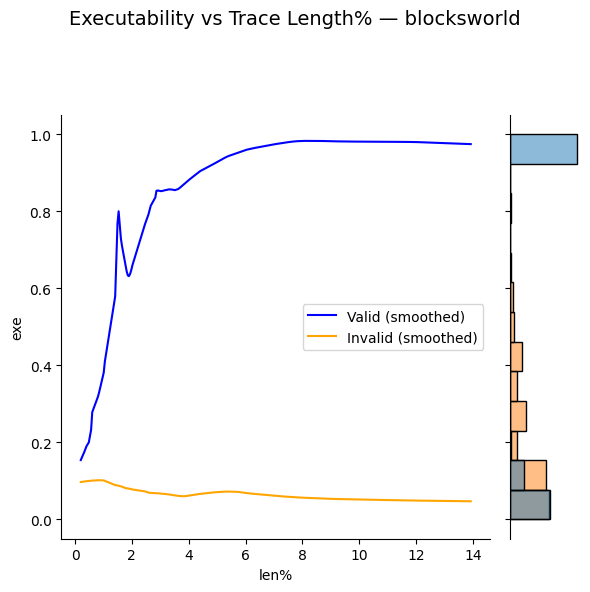

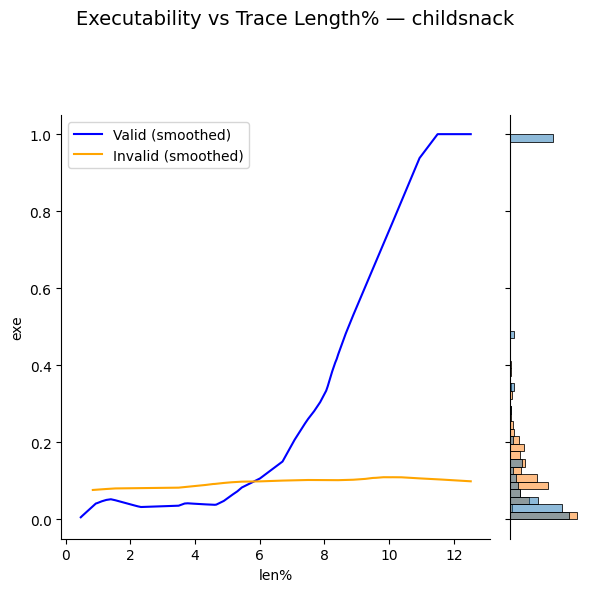

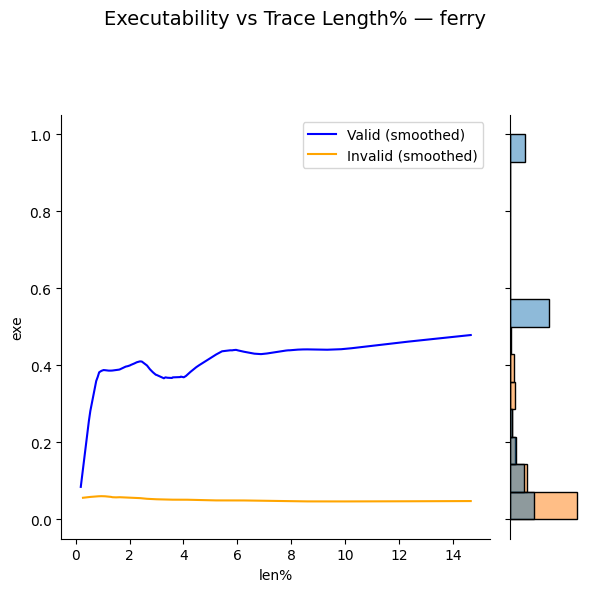

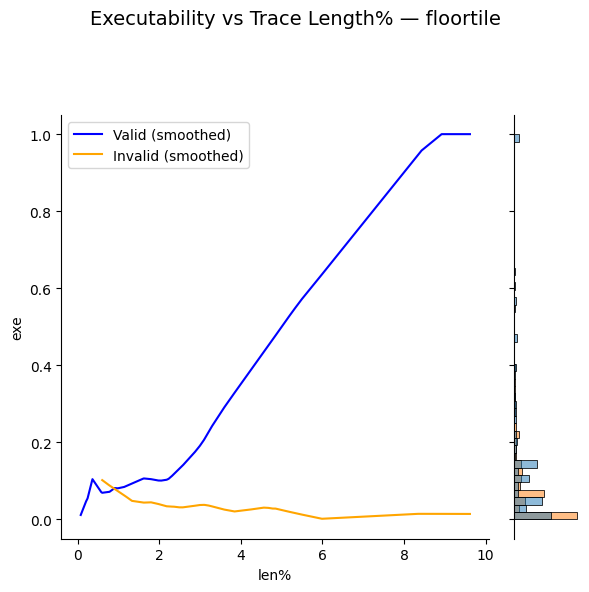

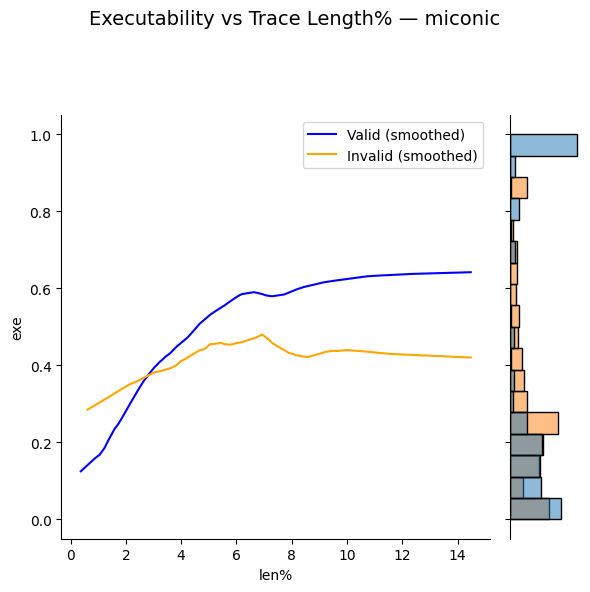

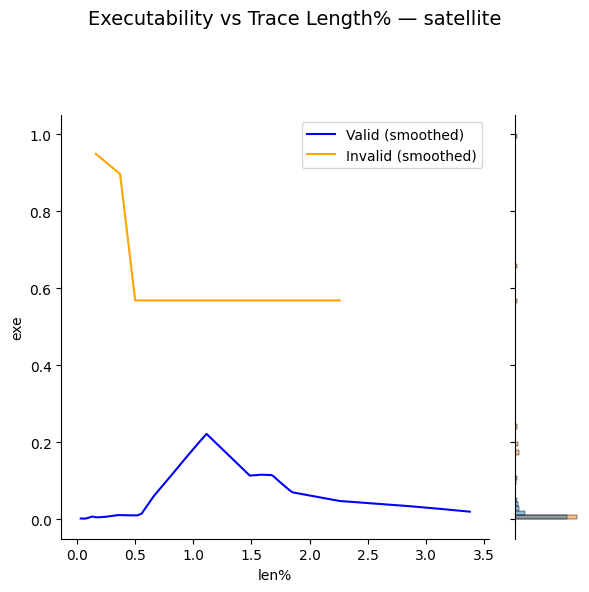

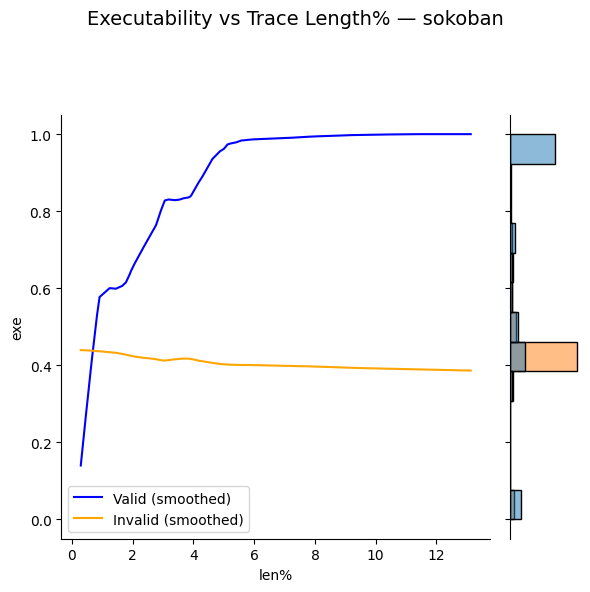

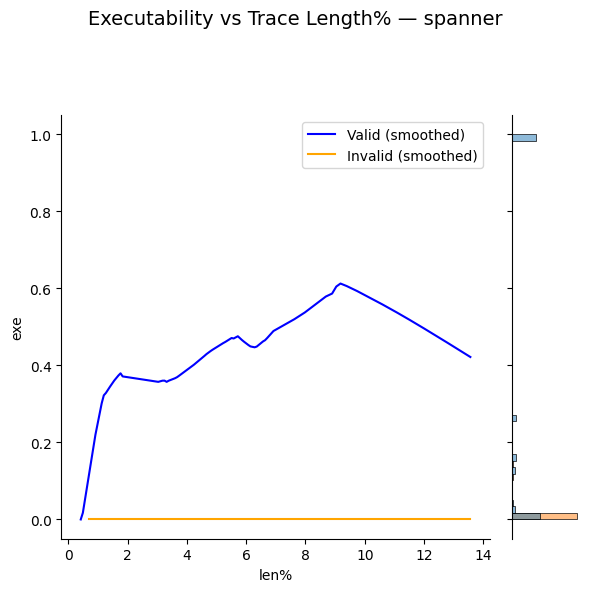

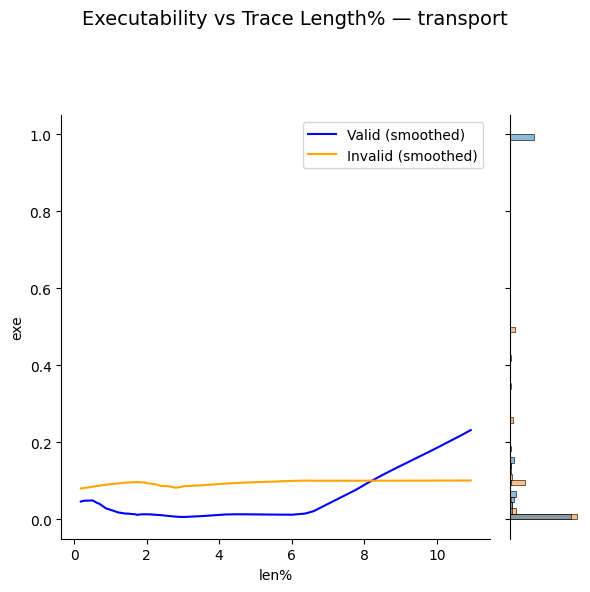

In [23]:


# Get unique domains
domains = df['domain'].unique()

for domain in domains:
    domain_df = df_by_len[df_by_len['domain'] == domain].copy()

    # Apply LOWESS smoothing
    valid_smoothed = lowess(domain_df['acceptance_rate'], domain_df['len%'], frac=0.3)
    filtered_df = domain_df[domain_df['acceptance_rate'] > 0.3]
    invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['len%'], frac=0.3)

    valid_smoothed[:, 1] = valid_smoothed[:, 1].clip(0, 1)
    invalid_smoothed[:, 1] = invalid_smoothed[:, 1].clip(0, 1)

    # Melt to long format for seaborn
    df_long = pd.melt(
        domain_df,
        id_vars=['len%'],
        value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
        var_name='type',
        value_name='exe'
    )

    # Create jointplot
    g = sns.jointplot(
        data=df_long,
        x='len%', y='exe', hue='type',
        kind='hist', alpha=0,
        height=6, marginal_kws=dict(common_norm=False, stat='density')
    )
    g.ax_marg_x.set_visible(False)

    # Overlay LOWESS lines
    g.ax_joint.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], color='blue', label='Valid (smoothed)')
    g.ax_joint.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], color='orange', label='Invalid (smoothed)')
    g.ax_joint.legend()

    # Add title
    g.fig.suptitle(f"Executability vs Trace Length% — {domain}", fontsize=14)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)

    # Show the plot
    plt.show()


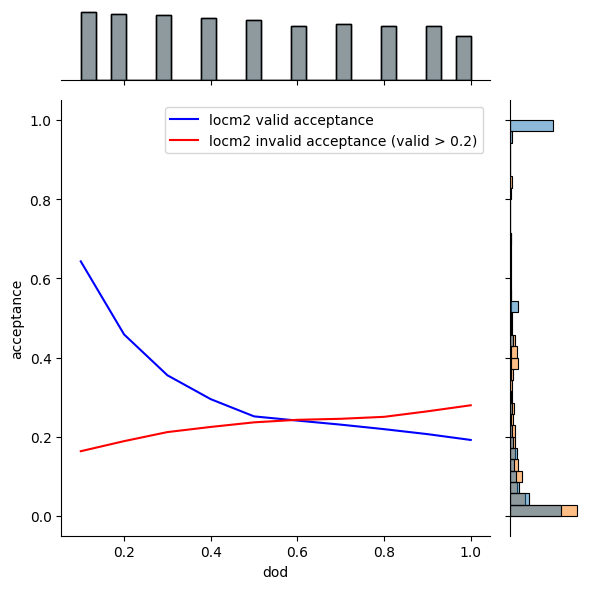

In [16]:
df_by_flex = df.sort_values(by='dod')

valid_smoothed = lowess(df_by_len['acceptance_rate'], df_by_len['dod'], frac=0.3)
filtered_df = df_by_len[df_by_len['acceptance_rate'] > 0.3]
invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['dod'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_len, id_vars=['dod'], value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
                  var_name='type', value_name='acceptance')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='dod', y='acceptance', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], label='locm2 valid acceptance', color='blue')
plt.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], label='locm2 invalid acceptance (valid > 0.2)', color='red')



plt.legend()
plt.tight_layout()
plt.show()

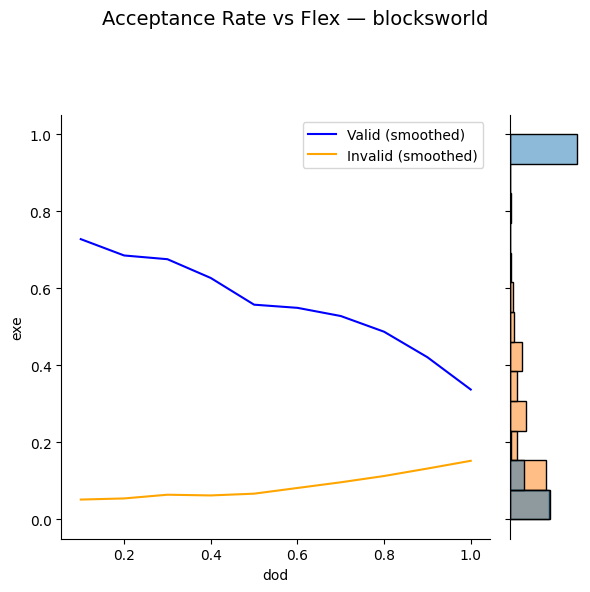

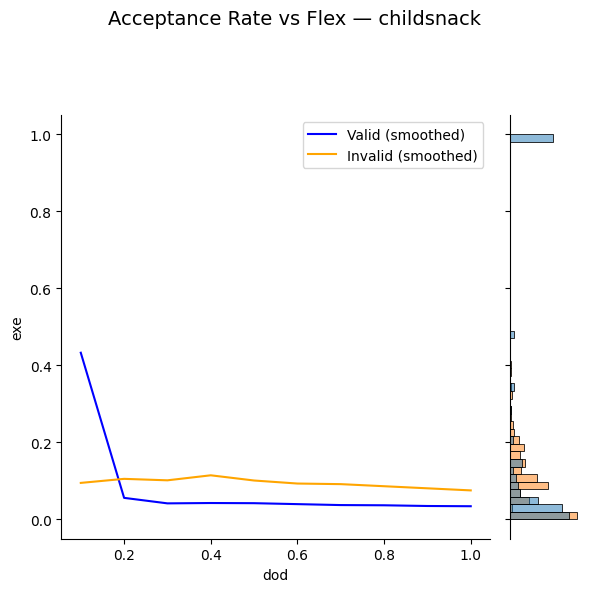

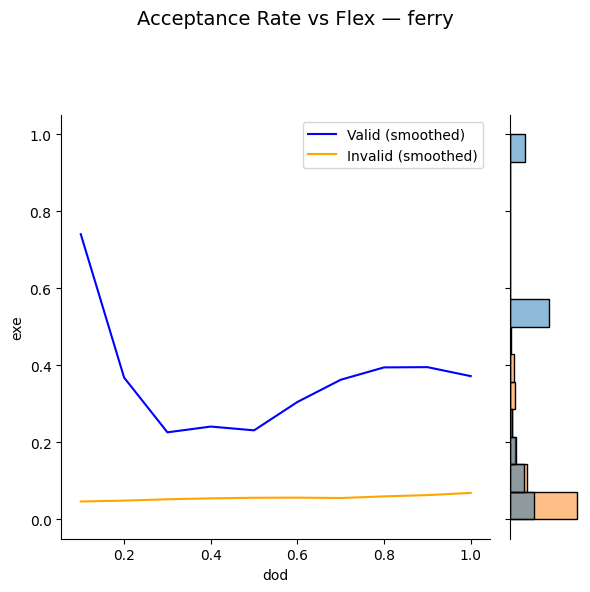

c:\Users\Apexmod\miniforge3\envs\llm\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


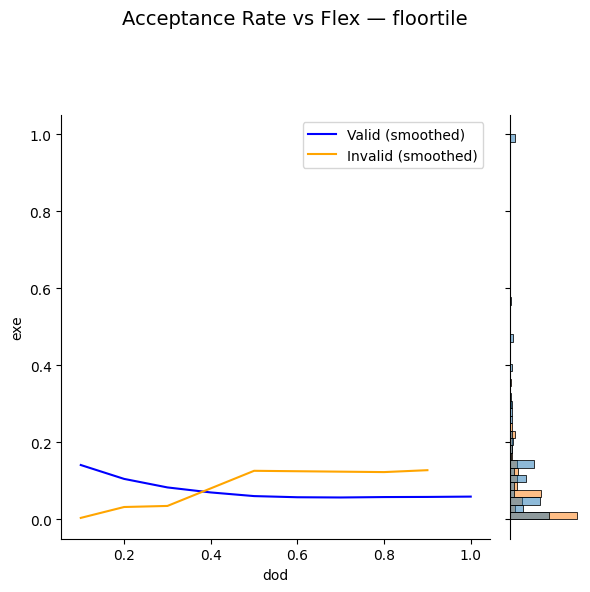

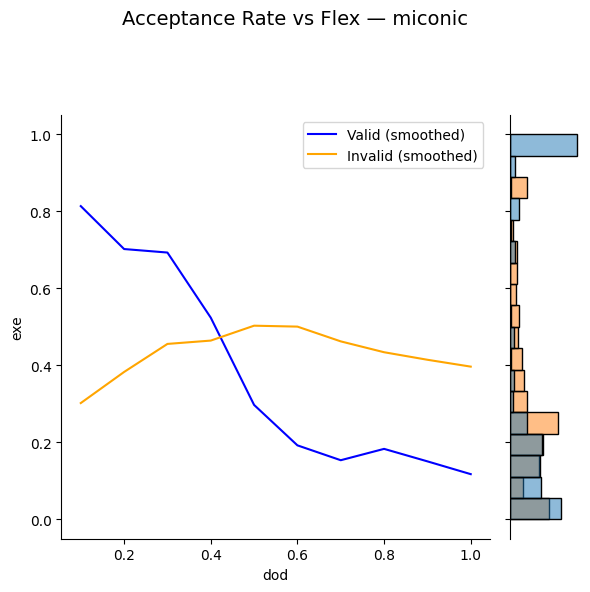

c:\Users\Apexmod\miniforge3\envs\llm\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


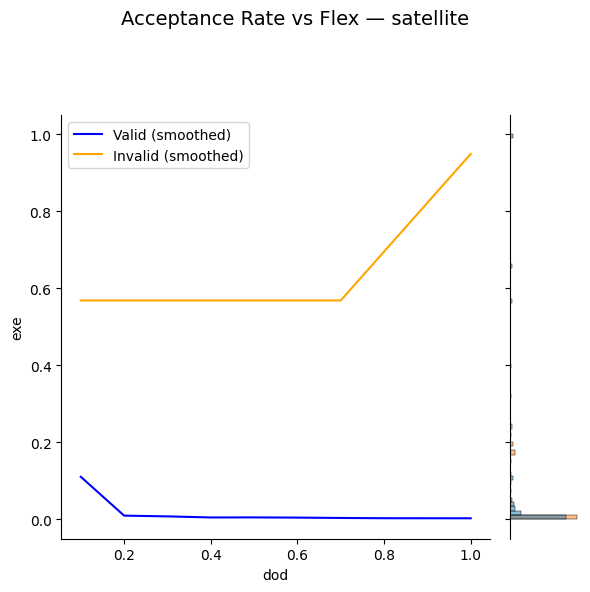

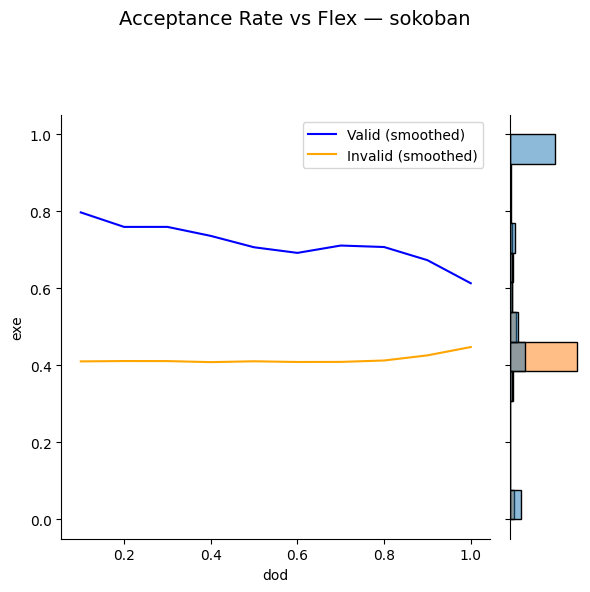

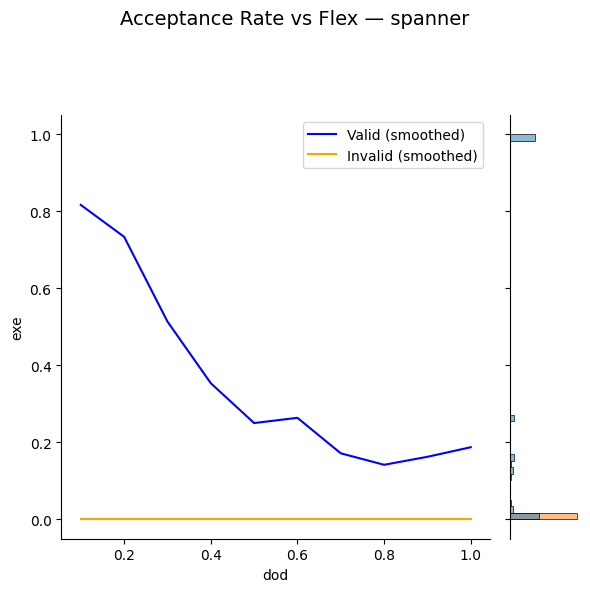

c:\Users\Apexmod\miniforge3\envs\llm\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


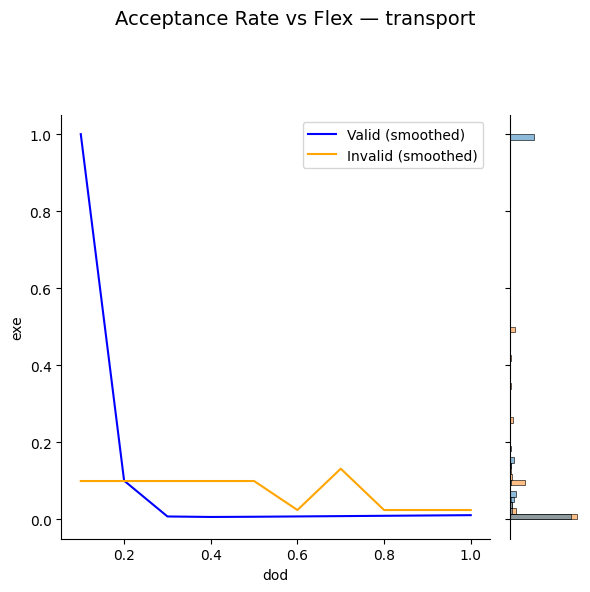

In [17]:

# Get unique domains
domains = df['domain'].unique()

for domain in domains:
    domain_df = df_by_flex[df_by_flex['domain'] == domain].copy()

    # Apply LOWESS smoothing
    valid_smoothed = lowess(domain_df['acceptance_rate'], domain_df['dod'], frac=0.3)
    filtered_df = domain_df[domain_df['acceptance_rate'] > 0.3]
    invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['dod'], frac=0.3)

    valid_smoothed[:, 1] = valid_smoothed[:, 1].clip(0, 1)
    invalid_smoothed[:, 1] = invalid_smoothed[:, 1].clip(0, 1)

    # Melt to long format for seaborn
    df_long = pd.melt(
        domain_df,
        id_vars=['dod'],
        value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
        var_name='type',
        value_name='exe'
    )

    # Create jointplot
    g = sns.jointplot(
        data=df_long,
        x='dod', y='exe', hue='type',
        kind='hist', alpha=0,
        height=6, marginal_kws=dict(common_norm=False)
    )
    g.ax_marg_x.set_visible(False)

    # Overlay LOWESS lines
    g.ax_joint.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], color='blue', label='Valid (smoothed)')
    g.ax_joint.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], color='orange', label='Invalid (smoothed)')
    g.ax_joint.legend()

    # Add title
    g.fig.suptitle(f"Acceptance Rate vs Flex — {domain}", fontsize=14)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)

    # Show the plot
    plt.show()


# Accuracy

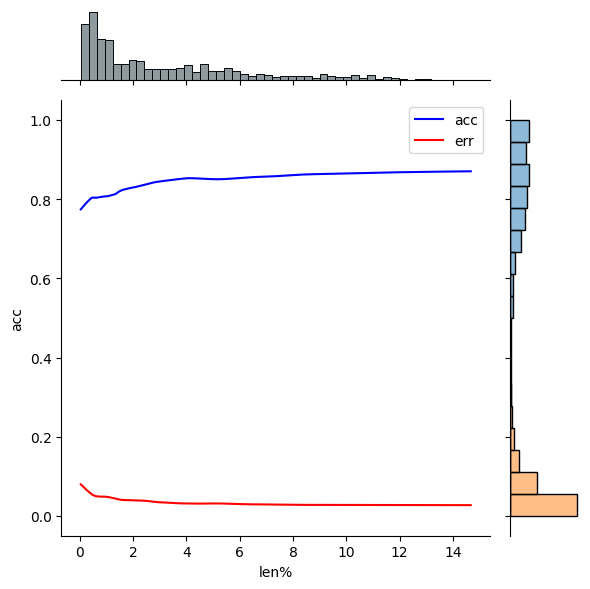

In [18]:

acc = lowess(df_by_len['accuracy'], df_by_len['len%'], frac=0.3)

err = lowess(df_by_len['error_rate'], df_by_len['len%'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_len, id_vars=['len%'], value_vars=['accuracy', 'error_rate'],
                  var_name='type', value_name='acc')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='len%', y='acc', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(acc[:, 0], acc[:, 1], label='acc', color='blue')
plt.plot(err[:, 0], err[:, 1], label='err', color='red')



plt.legend()
plt.tight_layout()
plt.show()

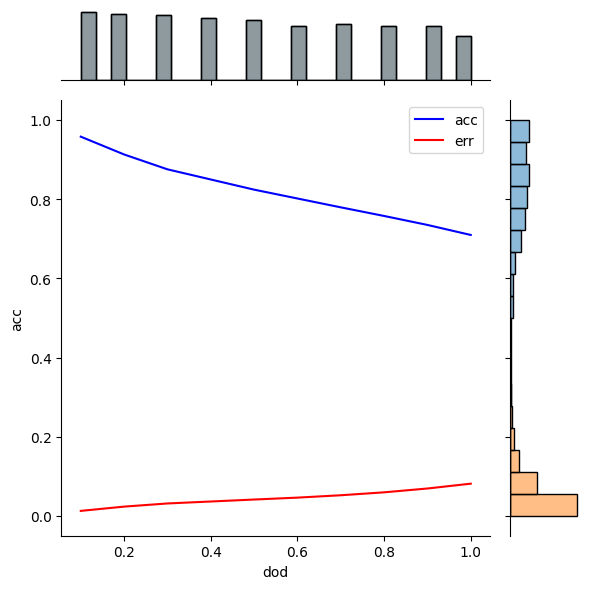

In [19]:


acc = lowess(df_by_flex['accuracy'], df_by_flex['dod'], frac=0.3)

err = lowess(df_by_len['error_rate'], df_by_len['dod'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_flex, id_vars=['dod'], value_vars=['accuracy', 'error_rate'],
                  var_name='type', value_name='acc')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='dod', y='acc', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(acc[:, 0], acc[:, 1], label='acc', color='blue')
plt.plot(err[:, 0], err[:, 1], label='err', color='red')



plt.legend()
plt.tight_layout()
plt.show()